In [1]:
# work in progress

In [2]:
# NOTE
# Calibration consists of multiple sections
# used for parameter estimation/validation + experimental instruction

# Pain threshold estimation
# Section 1: Preexposure to thermal stimuli
#   - familiarize the subject with the thermal stimuli
#   - binary responses to thermal stimuli
#   - Q: what kind of binary response? how many trials? how many temperatures? do we use the results?
# Section 2: Probabilistic pain threshold detection
#   - Bayesian adaptive design / sequential Bayesian design to:
#        1. update belief about the heat pain threshold and
#        2. decide on the temperature for the next trial.
#   - binary responses
#   - DONE
#
# Peri- or suprathreshold calibration
# Section 3: Scale translation
#   - didactic trials to support the transition from binary responses (Sections 1&2) to VAS responses
#   - purely instructional, to be done in psychopy
#   - Q: do I need this?
# Section 4: Rating training
#   - Low intensities are applied exclusively to familiarize the subject with the visuomotor demands of the VAS scale
#   - Q: do I need this?
# Section 5: Psychometric-perceptual scaling
#   - (Section 5, includes all steps up to Section 6)
#   - Fixed temperature increments to familiarize subject with possible perceptual range
#   - Fixed intensity target regression: Perithresholding with fixed temperature increments, e.g. +0.5 °C, +1 °C
#   - Fixed VAS target regression: Perithresholding with fixed VAS targets, e.g. inferred temperatures for 30 VAS, 60 VAS
#   - Adaptive VAS target regression: Perithresholding to elaborate poorly sampled areas of the VAS range
#   - Q: How does this work? What is the difference between fixed intensity target regression and fixed VAS target regression?
# Section 6: Calibration validation
#   - apply results from Section 5 for a number of trials, e.g. to assess robustness

In [3]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.stem == 'notebooks':
    PROJECT_DIR = PROJECT_DIR.parent
    sys.path.insert(0, '..')

In [10]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


# Step 1: Define a prior probability distribution for the heat pain threshold
min_temperature = 31
max_temperature = 45
mean_temperature = (min_temperature + max_temperature) / 2
std_temperature = 3.5
likelihood_std_temperature = 1

x = np.arange(min_temperature, max_temperature+0.1, 0.1) # temperature range
prior = stats.norm.pdf(x, loc=mean_temperature, scale=std_temperature)
prior /= np.sum(prior)  # normalize to make it a valid probability distribution

# Step 2: Start the experiment with a predetermined temperature
current_temperature = np.round(x[np.argmax(prior)],1) # = mean_temperature from prior

# Store distributions and temperatures for each trial
priors = []
likelihoods = []
posteriors = []
temperatures = [current_temperature]

# Step 3-end: Repeat for each trial
trials = 8

for trial in range(trials):
    # Collect the subject's response
    response = input(f'Is {current_temperature} °C painful? (y/n) ')

    # Define a likelihood function based on the response
    if response == 'y':
        likelihood = 1 - stats.norm.cdf(x, loc=current_temperature, scale=likelihood_std_temperature)
    else:
        likelihood = stats.norm.cdf(x, loc=current_temperature, scale=likelihood_std_temperature)

    # Decrease the standard deviation of the likelihood function as we gain more information
    likelihood_std_temperature *= 0.9

    # Update the prior distribution with the likelihood function to get a posterior distribution
    posterior = likelihood * prior
    posterior /= np.sum(posterior)  # normalize
    
    # Choose the temperature for the next trial based on the posterior distribution
    current_temperature = np.round(x[np.argmax(posterior)],1) # temperature with highest probability

    # Store the distributions and temperature
    priors.append(prior)
    likelihoods.append(likelihood)
    posteriors.append(posterior)
    temperatures.append(current_temperature)
    
    # Update the prior for the next iteration
    prior = np.copy(posterior)

print(f"{temperatures}\n{np.diff(temperatures)}")

[38.0, 36.4, 35.2, 34.2, 34.8, 35.2, 34.9, 34.7, 34.9]
[-1.6 -1.2 -1.   0.6  0.4 -0.3 -0.2  0.2]


In [11]:
# Interactive plot
import ipywidgets as widgets # NOTE: try reloading the vs window if duplicate plot appears

def plot_trial(trial):
    plt.clf()
    plt.plot(x, priors[trial], label='Prior')
    plt.plot(x, likelihoods[trial], label='Likelihood')
    plt.plot(x, posteriors[trial], label='Posterior')
    plt.title(f'Trial {trial+1}')
    plt.xlim([min_temperature, max_temperature])
    plt.ylim([0, 1])
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Probability')
    plt.xticks(np.arange(min_temperature, max_temperature+1, 1))
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

# Create a slider for the trial number
trial_slider = widgets.IntSlider(min=0, max=trials-1, step=1, value=0);

# Create Next and Previous buttons, define click events and link them to the buttons
next_button = widgets.Button(description="Next")
prev_button = widgets.Button(description="Previous")
def next_button_clicked(b): # b is the button instance
    if trial_slider.value < trial_slider.max:
        trial_slider.value += 1
def prev_button_clicked(b):
    if trial_slider.value > trial_slider.min:
        trial_slider.value -= 1
next_button.on_click(next_button_clicked)
prev_button.on_click(prev_button_clicked)

# Use the interact function to automatically update the plot when the slider is moved
out = widgets.interactive_output(plot_trial, {'trial': trial_slider});

# Display the slider and the buttons on top of the figure (box on box)
widgets.VBox([widgets.HBox([trial_slider, prev_button, next_button]), out])


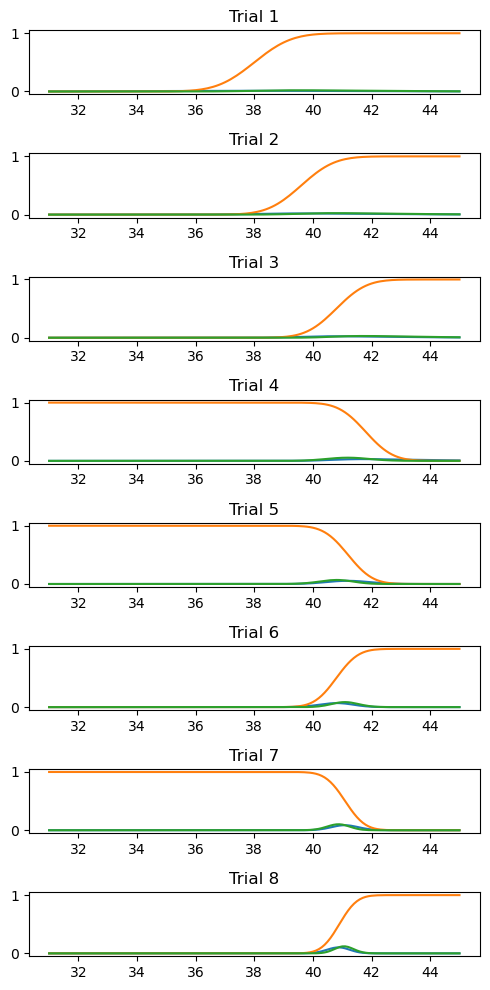

In [6]:
# One figure with all trials
fig, ax = plt.subplots(trials, 1, figsize=(5, 10))
for trial in range(trials):
    ax[trial].plot(x, priors[trial], label='Prior')
    ax[trial].plot(x, likelihoods[trial], label='Likelihood')
    ax[trial].plot(x, posteriors[trial], label='Posterior')
    ax[trial].set_title(f'Trial {trial+1}')
plt.tight_layout()
plt.show()